In [64]:
from datetime import datetime
import h5py as h5
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
sys.path.append('../../drlib/')
sys.path.append('/drBigBoy/darkRadio/daqAnalysisAndExperiments/run1p3/runTesting_3_30_23/')
import drlib as dr
import settings_runTest_3_30_23 as s





In [99]:
#Average and save spectra

#location of packed h5
dataDir         = '/drBiggerBoy/runTest_3_30_23/'
fileName        = 'packedh5.hdf5'
f               = h5.File(dataDir + fileName, 'r')
%matplotlib widget

def mad_np(arr):
    median = np.median(arr)
    return np.median(np.abs(arr-median))

def freq2Idx(freq, freqsAll):
    return int(freq/freqsAll[-1] * len(freqsAll))

def idx2freq(idx, freqs):
    return  ((freqs[-1] - freqs[0])/len(freqs) * idx) + freqs[0]

def avgSpecFromPacked(avgIdxs, aKey):
    sum = np.zeros(2**23+1)
    for i in avgIdxs:
        sum += f[aKey][:,i]
    avgSpec = sum/(len(avgIdxs))
    return avgSpec


def rollingMadLim(spec,
    nSigma = 1,
    order = 1,
    fc_numBins = 100
):
       
    specFiltered = dr.filterSpec(spec, fc_numBins=fc_numBins, order=order)
    window = 1000

    rollingMadArr = dr.rolling(specFiltered, window, 1, mad_np, numProc=48)

    filter_fc           = 30 * window
    filteredMadArr  = dr.filterSpec(rollingMadArr, order = 2, fc_numBins = filter_fc, type = 'lowpass')
    diffFilterMadPadArr = dr.nanPad(filteredMadArr, window)
    rollMadLim      = diffFilterMadPadArr * nSigma * 1.48
    return rollMadLim, specFiltered, nSigma, order, fc_numBins

# Get the nth greatest value in an array
# arr:          The array
# startIndex:   The starting index for where to start looking
# number:       Number corresponding to the nth greatest value (e.g. 1 is the
#               greatest value, 2 the 2nd greatest, etc.)
# Returns:      The index of the nth greatest value in the array
def getGreatest(arr, startIndex, number):
    arrSorted = np.sort(arr)[::-1]
    findVal = arrSorted[number]
    index = np.where(arr[startIndex:] == findVal)[0] + startIndex
    return index


# Get a frequency subset of all the data
# idx:            Indices of the data
# aKey:           Needed for identifying whether you're looking at antenna/terminator 
#                 data or veto data since the Teledyne can take both simultaneously
# startFrequency: The start frequency (in MHz)
# endFrequency:   The end frequency (in MHz)
# Returns:        A 2d numpy array that is the subset of all the data and a 1d numpy
#                 array of the frequencies                  
def getFreqSubset(idx, aKey, startFreq = 50, endFreq = 300):
    freqs = np.asarray(range(s.CH0_RECORD_LEN//2+1))*(s.CLOCK_RATE/s.CH0_SAMPLE_SKIP_FACTOR/s.CH0_RECORD_LEN)/1e6
    startFreqIdx = freq2Idx(startFreq, freqs)
    endFreqIdx = freq2Idx(endFreq, freqs)
    allData = []
    for i in idx:
       allData.append(np.asarray(f[aKey][startFreqIdx:endFreqIdx,i]))
    return np.asarray(allData), freqs[startFreqIdx:endFreqIdx]

# Get a date subset
# databaseDF: A .txt file with run descriptions that makes cutting on data much
#             easier/faster than going through the h5 files 
# idx:        A list of indices that describes what datasets are included in your data
#             (equivalently acquisition numbers)         
# allData:    2d numpy array of all your data
# startDate:  The latest date that you want - written in the same format as earliest date
# endDate:    The latest date that you want - written in the same format as earliest date
# Returns:    A 2d numpy array that is a subset of the input data, the dates that you 
#             selected (1d numpy array of datetime objects), and a 1d numpy array of indices 
def getDateSubset(databaseDF, idx, allData, startDate = '2023-03-30 18:44:26.994660', endDate = '2023-03-30 21:44:26.994660'):
    # There is an extra space in the datetimes right now. This is a lazy way to get rid
    # of it. I'm guessing that this won't always be true, so just be aware that this
    # may need to change,
    allDates = np.asarray([datetime.strptime(x[1:], "%Y-%m-%d %H:%M:%S.%f") for x in np.asarray(databaseDF['DATETIME'])])
    
    # Get acquisition numbers
    acqNums = np.asarray(databaseDF['ACQ NUM'])
    
    #
    try:
        earliest = datetime.strptime(startDate, "%Y-%m-%d %H:%M:%S.%f")
        latest = datetime.strptime(endDate, "%Y-%m-%d %H:%M:%S.%f")
    except:
        # Return original dataset if date range is input incorrectly
        print('DATE NOT IN YEAR-MONTH-DAY HOUR:MINUTE:SECOND.MICROSECOND FORMAT')
        datetimeSubset = np.asarray([allDates[x] for x in idx])
        return allData, datetimeSubset, idx
    
    # Get date range
    minIndex = (np.abs(np.asarray(allDates) - earliest)).argmin()
    maxIndex = (np.abs(np.asarray(allDates) - latest)).argmin()

    # Get indices subset 
    acqSubset = acqNums[minIndex:maxIndex]
    minIdx = (np.abs(np.asarray(acqSubset) - idx[0])).argmin()
    maxIdx = (np.abs(np.asarray(acqSubset) - idx[-1])).argmin()

    # Get indices/date/data subsets and return
    idxSubset = np.asarray(idx[minIdx:maxIdx])
    datetimeSubset = np.asarray([allDates[x] for x in idxSubset])
    dataSubset = np.asarray(allData[minIdx:maxIdx])

    return dataSubset, datetimeSubset, idxSubset


totalAcqs       = int(open(s.SAVE_DIRECTORY + 'database.txt', 'r'
                    ).readlines()[-1].split(',')[0].strip()) + 1 

print(totalAcqs)
    

#Average, filter and save - Not necessary to do more than once
# Should not need to be rerun unless you want to re-save data
# Still useful to go through especially to see how to average data
if 0:
    antIdxs     = range(0, totalAcqs-1, 2)[0:-1]
    termIdxs    = range(1, totalAcqs-1, 2)
    antVetoIdxs    = range(0, totalAcqs-1, 2)[:-1]
    avgAntSpec  = avgSpecFromPacked(antIdxs, 'spec_W_chB')
    avgtermSpec = avgSpecFromPacked(termIdxs, 'spec_W_chB')
    avgAntVeto = avgSpecFromPacked(antVetoIdxs, 'spec_W_chA')

    np.save('./avgSpecs_gitignore/avgAntSpec_W_11e6FFTs_3_30_23', avgAntSpec)
    np.save('./avgSpecs_gitignore/avgTermSpec_W_11e6FFTs_3_30_23', avgtermSpec)
    np.save('./avgSpecs_gitignore/avgAntVetoSpec_W_11e6FFTs_3_30_23', avgtermSpec)

    print('Done saving raw spectra')

    #filter/rolling mad limit and save
    antRollingMadLim, antFilt, Sigma, order, fc_numBins     = rollingMadLim(avgAntSpec)
    termRollingMadLim, termFilt, nSigma, order, fc_numBins   = rollingMadLim(avgtermSpec)

    np.save(f'./avgSpecs_gitignore/antRollingMadLim_W_11e6FFTs_nSigma{nSigma}_order{order}_fc{fc_numBins}_3_30_23', antRollingMadLim)
    np.save(f'./avgSpecs_gitignore/termRollingMadLim_W_11e6FFTs_nSigma{nSigma}_order{order}_fc{fc_numBins}_3_30_23', termRollingMadLim)
    np.save(f'./avgSpecs_gitignore/antFilt_W_11e6FFTs_nSigma{nSigma}_order{order}_fc{fc_numBins}_3_30_23', antFilt)
    np.save(f'./avgSpecs_gitignore/termFilt_W_11e6FFTs_nSigma{nSigma}_order{order}_fc{fc_numBins}_3_30_23', termFilt)

    f.close()


1100


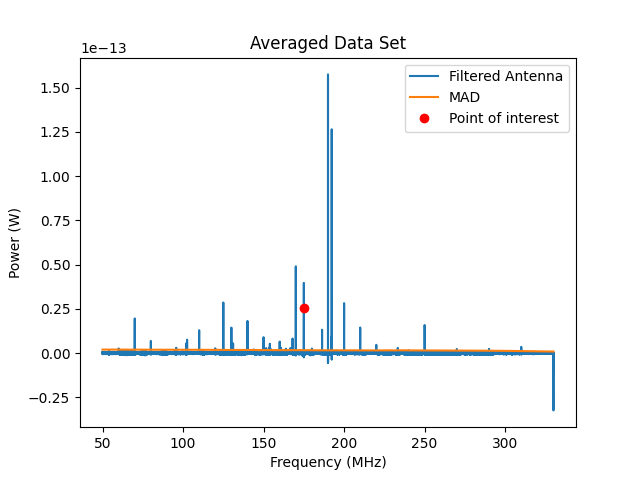

In [101]:
# Plotting the total average data along with the 6σ limit line
%matplotlib widget
nSigma      = 6
order       = 1
fc_numBins  = 100

# Filtered antenna spectrum
filtAntSpec = np.load(f'./avgSpecs_gitignore/antFilt_W_11e6FFTs_nSigma1_order{order}_fc{fc_numBins}_3_30_23.npy', 
    allow_pickle=True)

# Rolling mean absolute deviation (MAD)
antRollingMadLim   = nSigma * np.load(f'./avgSpecs_gitignore/termRollingMadLim_W_11e6FFTs_nSigma1_order{order}_fc{fc_numBins}_3_30_23.npy',
    allow_pickle=True)

# Get the frequency using the run settings file.
# Note: Everything is in MHz
freqs = np.asarray(range(s.CH0_RECORD_LEN//2+1))*(s.CLOCK_RATE/s.CH0_SAMPLE_SKIP_FACTOR/s.CH0_RECORD_LEN)/1e6

# Don't look below the frequency range we care about
# Note that you could also do this for the end frequency as well
startFreq = 50

# Get the index of the start frequency
startFreqIdx = freq2Idx(startFreq, freqs)

# List comprehension for getting the list of candidate frequencies
# Simply subtracts the rolling MAD array from the filtered, averaged
# antenna spectrum and looks for indices where this value is greater than 0.
# This supposes that the mean of the filtered antenna spectrum is 0, which
# it is by construction. 
candidateFreqs = (np.asarray([x for x in freqs[(antRollingMadLim - filtAntSpec) <= 0] if x > startFreq]))

# Just a way to more easily identify candidates. Just looks for the nth greatest
# value in the filtered antenna spectrum array. For example, if you wanted to
# find the third greatest value you would call getGreatest(filtAntSpec, startFreqIdx, 3).
# This is doing no checking to see if the value you get is actually a candidate.
# It's simply used for visuals to easily zoom in on candidates.
greatestIndex = getGreatest(filtAntSpec, startFreqIdx, 3)

# Plot filtered antenna spectrum, rolling MAD limit, and location of interesting
# frequencies
plt.plot(freqs[startFreqIdx:], filtAntSpec[startFreqIdx:], label = 'Filtered Antenna')
plt.plot(freqs[startFreqIdx:], antRollingMadLim[startFreqIdx:], label = 'MAD')
plt.plot([freqs[greatestIndex]], [filtAntSpec[greatestIndex]], 'ro', label = 'Point of interest')
plt.title('Averaged Data Set')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Power (W)')
plt.legend()
plt.show()



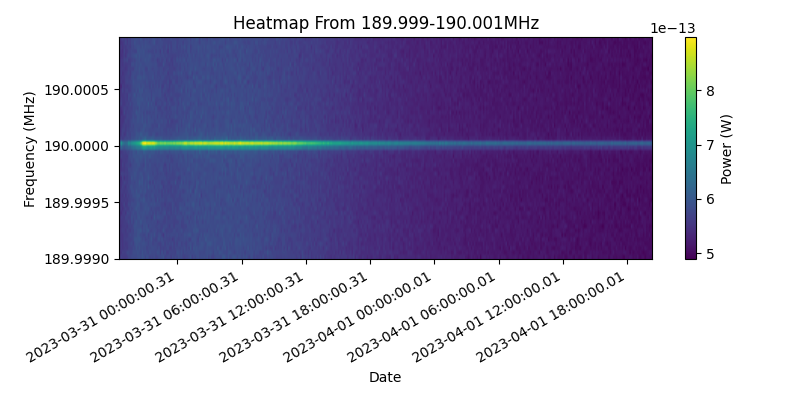

In [98]:
# Make cuts on data 
# Suggestion: Make frequency cuts first since there are so many bins
# that it takes a while to create an array with all the data 
databaseDF = pd.read_csv(f'{dataDir}database.txt')

# Get the indices of all the antenna positions
antIdxs     = range(0, totalAcqs-1, 2)[0:-1]

# Start and end frequencies
startFreq = 189.999
endFreq = 190.001

# Make a frequency cut
allData, freqs = getFreqSubset(antIdxs, 'spec_W_chB', startFreq = 189.999, endFreq = 190.001)

# Make a date cut
dataDateCut, datetimeSubset, idxSubset = getDateSubset(databaseDF, antIdxs, allData, \
                                         startDate = '2023-03-30 18:44:26.994660', \
                                         endDate = '2023-03-31 19:44:26.994660')

# Conver the dates to numbers so cmap can make limits
dateNums = mdates.date2num(datetimeSubset)

# Plot the heatmap
plt.figure(figsize=(8, 4))
plt.imshow(dataDateCut.T, cmap='viridis',
            extent=[dateNums[0], dateNums[-1], freqs[0], freqs[-1]],
            aspect='auto', origin='lower')
plt.colorbar(label='Power (W)')
plt.xlabel('Date')
plt.ylabel('Frequency (MHz)')
plt.title('Heatmap From ' + str(startFreq) + '-' + str(endFreq) + 'MHz')

# Format the x-axis with dates (only include 2 digits of precision for the 
# microseconds)
dateFormat = mdates.DateFormatter("%Y-%m-%d %H:%M:%S.%02d")
plt.gca().xaxis.set_major_formatter(dateFormat)
plt.gcf().autofmt_xdate()

# Turn off offset
plt.gca().get_yaxis().get_major_formatter().set_useOffset(False)
plt.tight_layout()
plt.show()